# Multivariate Generalized Gaussian Spatial Model

## Generative Model with Stochastic representation: $\mathbf{x} = \tau \Sigma^{1/2} \mathbf{u}$
1. $\mathbf{u} \in \mathbb{R}^2$ is a random vector sampled from a unit circle
2. Scatter matrix $\Sigma = m \mathbf{M}$
3. Shape parameter $\beta$
4. $\tau^{2 \beta} \sim \Gamma(\frac{p}{2 \beta}, 2)$

In [2]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from scipy.stats import special_ortho_group


def random_scatter(m=1, p=2):
    M = np.random.rand(p, p)
    M = 0.5 * (M + M.T)
    return m * M / M.trace()


class MultiVarGenGaussian:
    def __init__(self, mu, Sigma, beta, p=2):
        self._p = p
        self._mu = mu
        self._beta = beta
        self.Sigma = Sigma

    @property
    def dim(self):
        return self._p

    @dim.setter
    def dim(self, val):
        self._p = val

    @property
    def mu(self):
        return self._mu

    @mu.setter
    def mu(self, val):
        self._mu = val

    @property
    def Sigma(self):
        return self._Sigma

    @Sigma.setter
    def Sigma(self, val):
        if val:
            self._Sigma = val
        else:
            self._Sigma = random_scatter(1, self._p)

    @property
    def beta(self):
        return self._beta

    @beta.setter
    def beta(self, val):
        self._beta = val

    def sample(self, n_samples=1000, noise_level=0):
        phi = 2 * np.pi * np.random.random(n_samples)
        u = np.array([np.cos(phi), np.sin(phi)]) + self._mu[:, np.newaxis]
        tau = np.power(
            np.random.gamma(0.5 * self._p / self._beta, 2, n_samples), 0.5 / self._beta
        )
        x = tau * np.matmul(np.sqrt(self._Sigma), u)
        # R = special_ortho_group.rvs(self._p)
        # x = np.matmul(R, x)
        if noise_level > 0:
            mu = self._mu[:, np.newaxis]
            sigma = np.std(x, axis=1)[:, np.newaxis]
            x += sigma * np.random.randn(self._p, x.shape[1]) + mu

        return x

    def pdf(self, X):
        d = X.shape[1]
        diff = X - self._mu
        exponent = -0.5 * np.sum(
            np.power(np.dot(diff, np.linalg.inv(self._Sigma)), 2), axis=1
        )
        exponent = np.power(1 + exponent / self._beta, -(self._beta + d) / 2)
        return np.prod(exponent)

    def log_likelihood(self, X):
        return np.sum(np.log(self.pdf(X)))


def estimate_params(X):
    n, d = X.shape
    mu0 = np.mean(X, axis=0)
    Sigma0 = np.cov(X.T)
    beta0 = 3.0
    model = MultiVarGenGaussian(mu0, Sigma0, beta0)
    res = minimize(lambda beta: -model.log_likelihood(X), beta0, method="BFGS")
    beta_hat = res.x[0]
    model.beta = beta_hat
    return model

## Animate Sampling Process

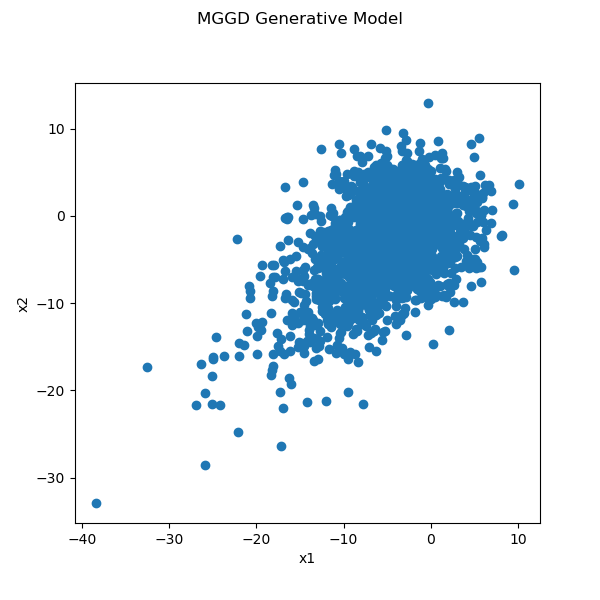

In [3]:
mvgg = MultiVarGenGaussian(mu=np.random.rand(2) * 10 - 5, Sigma=None, beta=0.5, p=2)
x = mvgg.sample(2000, 0.25)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_aspect(1)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
dots = ax.scatter(x[0, :], x[1, :])


def init():
    x = mvgg.sample(2000, 0.25)
    dots.set_offsets(x.T)
    return dots


def update(frame):
    x = mvgg.sample(2000, 0.25)
    dots.set_offsets(x.T)
    ax.set_xlim(x[0, :].min() - 1, x[0, :].max() + 1)
    ax.set_ylim(x[1, :].min() - 1, x[1, :].max() + 1)

    return dots


ani = FuncAnimation(
    fig, update, repeat=False, frames=10, interval=400, init_func=init, blit=True
)

plt.suptitle("MGGD Generative Model")
plt.show()

## Parameter Estimation with Neural Sampling

### Reference
1. Paninski L, Pillow JW, Simoncelli EP. Maximum likelihood estimation of a stochastic integrate-and-fire neural encoding model. Neural Comput. 2004 Dec;16(12):2533-61. doi: 10.1162/0899766042321797. PMID: 15516273.Paninski L, Pillow JW, Simoncelli EP. Maximum likelihood estimation of a stochastic integrate-and-fire neural encoding model. Neural Comput. 2004 Dec;16(12):2533-61. doi: 10.1162/0899766042321797. PMID: 15516273.
2. Kappel D, Habenschuss S, Legenstein R, Maass W (2015) Network Plasticity as Bayesian Inference. PLOS Computational Biology 11(11): e1004485. https://doi.org/10.1371/journal.pcbi.1004485Kappel D, Habenschuss S, Legenstein R, Maass W (2015) Network Plasticity as Bayesian Inference. PLOS Computational Biology 11(11): e1004485. https://doi.org/10.1371/journal.pcbi.1004485

In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import nengo
import nengo_dl
import numpy as np
from TouchDataset import TouchDataset

# Prepare dataset
height, width = 15, 15
n_dims = height * width
dataset = TouchDataset(filepath="../data/touch.pkl", noise_level=0.25, scope=(0.0, 1.0))
X_train, y_train, X_test, y_test = dataset.split_set(ratio=0.5)

# Simulation parameters
dt = 1e-3
n_filters = 3
shape_in = 6
kernel_size = 5
strides = kernel_size - 1
channels_last = True


def input_func(t):
    index = int(t // dt)
    if index >= len(X_train):
        sample = X_train[-1]
    else:
        sample = X_train[index]
    sample /= np.sum(sample)
    return sample.flatten
 

# Create the Nengo model
with nengo.Network(label="MVGG") as net:
    sin = nengo.Node(input_func)  # Input is a sine

    transform = nengo.Convolution(
        n_filters=n_filters,
        input_shape=shape_in,
        kernel_size=kernel_size,
        strides=strides,
        padding="valid",
        channels_last=channels_last,
        init=nengo_dl.dists.Glorot(scale=1.0 / np.prod(kernel_size)),
    )

    inp = nengo.Ensemble(n_neurons=36, dimensions=n_dims)
    nengo.Connection(sin, inp, transform=conv2d)

    # Define probes
    inp_probe = nengo.Probe(inp, synapse=0.01)
    inp_spikes = nengo.Probe(inp.neurons)

# Simulate the network
with nengo.Simulator(net, dt=dt) as sim:
    sim.run(10)

plt.close("all")
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot(211)
ax0.plot(sim.trange(), sim.data[inp_spikes][:, 1])
ax1 = plt.subplot(223)
ax1.imshow(X_train[100])
ax2 = plt.subplot(224)
ax2.imshow(sim.data[inp_spikes][100].reshape((6, 6)))
plt.show()

ModuleNotFoundError: No module named 'nengo_dl'

In [98]:
sample = input_func(1)
x = np.arange(15).repeat(15)
y = np.tile(np.arange(15), 15)
coor = np.vstack([x, y])
v = np.tile(sample.flatten(), 2).reshape(2, -1)
res = coor * v
np.sum(res, axis=1)

array([6.93692648, 6.98598121])